# Causal Effect Inference

We are in the context of an **observational study**: we observe outcomes ($Y$) for available subjects (with many characteristics $X_i$) on the variables of interest ($T$) without control over this variable. This setting poses a problem: there may be lurking variables not taken into account who affect both the treatment and the outcome (i.e., confounders) making the establishment of cause and effect much harder.

This stands in contrast to Randomized Clinical Trials (RCTs), where instead we can randomize the assignment of the subjects to the values of the variable of interest so that no confounders are present.

**Causal Graphical Model (Causal Bayesian Network)**

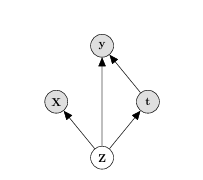

We **observe** the features $X_i$, the treatment $T$ and the outcome $Y$, but we do **not observe** the hidden confounder $Z$!

Our **objective** is to estimate the **Average Treatment Effect** (ATE), i.e., the effect of $T$ on $Y$.

In [1]:
from data_gen import synthetic_dataset_pyro, synthetic_dataset_linear
from dowhy import CausalModel
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pyro
from pyro.contrib.cevae import CEVAE
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import logging
import itertools


logging.getLogger("pyro").setLevel(logging.DEBUG)
logging.getLogger("pyro").handlers[0].setLevel(logging.DEBUG)

/home/giovanni/Desktop/pml_project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
data = synthetic_dataset_pyro(n=1000, beta=2.0, num_proxies=10,prior_type = "gaussian", seed=0)
data.keys()
length_x = len(data["x"][1]) 

#clone
data_original = data.copy()

In [46]:
# translating the dictionary in a dataframe
# I need to change the x matrix in different x columns
for i in range(data["x"].shape[1]):
    data["x_"+str(i)] = data["x"][:,i]

data.pop("x",None)

data_df = pd.DataFrame.from_dict(data)
data_df.head()

,t,y,z,ite,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,0.0,-2.208010,-1.125840,0.437080,-1.731487,-1.221312,1.362937,-1.761153,1.143016,1.214882,1.167682,0.343493,0.194201,0.303988
1,0.0,-0.875835,-1.152360,0.423820,-0.456844,1.407218,1.781436,-1.574662,0.310614,0.521926,-0.086948,-0.668354,0.761953,2.022159
2,0.0,-4.025739,-0.250579,0.874711,1.478320,-1.480874,0.375845,-0.744108,0.327447,0.911712,-1.282674,-1.145216,0.744192,0.787970
3,1.0,0.659674,-0.433879,0.783061,-0.632539,-1.681831,-1.748725,0.701550,-0.586185,1.948595,-0.788646,-2.934193,0.032010,0.836807
4,0.0,1.993935,0.848710,1.424355,1.707293,0.087381,-1.271084,-1.395154,-0.485180,0.207355,-1.430470,1.030292,-1.312681,-1.048788


We can obtain a naive estimate for the ATE by taking the mean of the outcome in the two groups in the dataset (those that received the treatment and those who didn't). We call this estimate "unadgusted" because we are not considering any of the covariates that can affect the treatment effect.

In [47]:
data_1 = data_df[data_df["t"]==1.0]
data_0 = data_df[data_df["t"]==0.0]

print("Unadjusted ATE", np.mean(data_1["y"])- np.mean(data_0["y"]))

Unadjusted ATE 2.6313312


## First strategy: assuming "No hidden confounders"

Assuming that there are no hidden confounders (also called **unconfoundness**) means that we consider the $X_i$ to be the only confounders and thus we consider them to be measured!

In this case the set of variables $X_i$ satisfy the back-door criterion and we can apply classical methods for causal inference.

In [40]:
# model = CausalModel(data_df, treatment="t", outcome="y", common_causes="z")
# this would be the real model since we know how the data was generated
# however, in a real setting, we don't usually have access to the real confounders and we consider the proxies variables we have for it instead  

model = CausalModel(data_df, treatment="t", outcome="y", common_causes=["x_"+str(i) for  i in range(0,10)])

In [ ]:
# this doesn't work in all python enviroments, for reference look at the generated image
#model.view_model(file_name="causal_model_no_hidden_confounder")

We identify the **estimand** using the back-door criterion. Again, we remark the need for the unconfoundedness assumption.

The estimand type is **non parametric** because we are **not** assuming any parametric model for the treatment effect.

The other two types of estimand (instrumental variable and front-door criterion) are **not** available because there are no instrumental variables or mediators in the causal graph. 


In [41]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_9,x_3,x_6,x_5,x_1,x_8,x_2,x_7,x_4,x_0])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_9,x_3,x_6,x_5,x_1,x_8,x_2,x_7,x_4,x_0,U) = P(y|t,x_9,x_3,x_6,x_5,x_1,x_8,x_2,x_7,x_4,x_0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



We want to compute how the value of $y$ will change with respect to $T$, controlling for all $X_i$.

For this purpose, we estimate the ATE using the linear regression to approximate the conditional probability $p(y|x,t)$.

In [ ]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)


We can also explicitely compute the linear regression using scikit-learn: we verify that the result is the same!

In [48]:
import torch
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

class LinearModel:
    def __init__(self, **kwargs):
        self.model = LinearRegression(**kwargs)

    def fit(self, x, t, y, **fit_kwargs):
        # Convert to numpy if input is torch.Tensor
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
        if isinstance(t, torch.Tensor):
            t = t.detach().cpu().numpy()
        if isinstance(y, torch.Tensor):
            y = y.detach().cpu().numpy()

        X = np.concatenate([t[:, None], x], axis=1)
        self.model.fit(X, y, **fit_kwargs)
        y_pred = self.model.predict(X)
        mse = mean_squared_error(y, y_pred)
        return [mse]  # Fake ELBO for compatibility

    def ite(self, x):
        if isinstance(x, torch.Tensor):
            x_np = x.detach().cpu().numpy()
        else:
            x_np = x

        X1 = np.concatenate([np.ones((x_np.shape[0], 1)), x_np], axis=1)
        X0 = np.concatenate([np.zeros((x_np.shape[0], 1)), x_np], axis=1)
        y1 = self.model.predict(X1)
        y0 = self.model.predict(X0)
        diff = y1 - y0
        return torch.tensor(diff, dtype=torch.float32).reshape(-1, 1)


In [49]:
feature_cols = [f'x_{i}' for i in range(10)]
x = data_df[feature_cols]   
t = np.asarray(data_df['t'])
y = data_df['y']

linear_model = LinearModel()
linear_model.fit(x, t, y)          

ite = linear_model.ite(x)         
ate = ite.mean().item()
print("Average Treatment Effect (ATE):", ate)


Average Treatment Effect (ATE): 1.467006802558899


We estimated that receiving the treatment (t=1) increases the outcome of $1.826$ units after adjusting for covariates. This estimates has a very small p-value, suggesting that this effect is statistically significant.

Other types of estimation are possible, we try a couple more.

In [ ]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching", test_significance=True
)

print(estimate)

In [ ]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting", test_significance=True
)

print(estimate)

With different estimation methods we have obtained the following results:
- $1.82$ with linear regression
- $1.66$  with propensity score matching
- $1.72$ with propensity score weighting

**Remark**: I also verified that, if I give to the model the real hidden confounder (Z), it correctly predicts a causal effect close to 1 for all estimation methods!

## Second strategy: keeping into account the latent variable

If we think that there must be an hidden confounder that we have to account for, we can use the Causal Effect Variational AutoEncoder (CEVAE) to try to estimate it based on the available data.


In [ ]:
# # optimal hyperparameters till now
# cevae = CEVAE(
#     feature_dim=length_x,
#     latent_dim=1,
#     outcome_dist="normal",
#     num_layers=5,
#     hidden_dim=300
#     )

# losses = cevae.fit(
        # x, t, y,
        # num_epochs=100,
        # batch_size=100,
        # learning_rate=5e-4,
        # learning_rate_decay=0.1,
        # weight_decay=1e-6
        # )

In [50]:
x, t, y   = (
    data_original["x"],
    data_original["t"],
    data_original["y"]
    )

z = data_original["z"]

length_x  = x.shape[1]

# ----------------------------- train-test split ----------------------------- #

x_train, x_test, t_train, t_test, y_train, y_test = train_test_split(
    x, t, y, test_size=0.2, random_state=0
)

INFO 	 Training with 8 minibatches per epoch


DEBUG 	 step     0 loss = 28.256
DEBUG 	 step   100 loss = 18.2147
DEBUG 	 step   200 loss = 17.7713
DEBUG 	 step   300 loss = 18.2849
DEBUG 	 step   400 loss = 18.2152
DEBUG 	 step   500 loss = 17.2466
DEBUG 	 step   600 loss = 17.163
DEBUG 	 step   700 loss = 17.4356


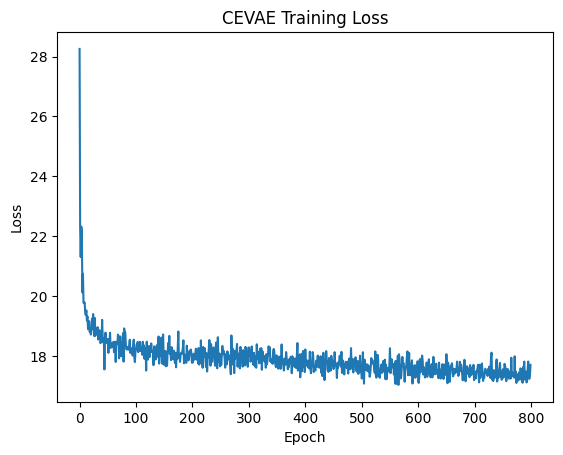

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.25185


Estimated (test) ATE: 1.2518
True ATE: 1.0145


In [51]:
# before every training run
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

losses = cevae.fit(
    x_train, t_train, y_train,
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    # learning_rate_decay=0.1,
    # weight_decay=1e-6
    )

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training Loss')
plt.show()

# Estimate ITEs and ATE
ite = cevae.ite(x_test)
ate = ite.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate:.4f}")
print(f"True ATE: {data['ite'].mean().item():.4f}")

In [ ]:
# Save the model
torch.save(cevae, "cevae_model_full.pth")

cevae_loaded = torch.load("cevae_model_full.pth", weights_only=False)

# Assessment

In [ ]:
import torch, types
from torch.utils.data import DataLoader, TensorDataset
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.optim import ClippedAdam
from pyro.contrib.cevae import PreWhitener, TraceCausalEffect_ELBO

def train_cevae(
    model,                      # a CEVAE instance
    x, t, y,                    # training data
    x_val=None, t_val=None, y_val=None,   # optional validation data
    num_epochs=100, batch_size=100,
    lr=1e-3, lr_decay=0.1, weight_decay=1e-4,
    log_every=10,
):
    model.whiten = PreWhitener(x)           # <-- same pre-whiten stats
    train_loader = DataLoader(TensorDataset(x, t, y),
                              batch_size=batch_size, shuffle=True,
                              generator=torch.Generator(device=x.device))
    num_steps = num_epochs * len(train_loader)
    optim = ClippedAdam({"lr": lr,
                         "weight_decay": weight_decay,
                         "lrd": lr_decay ** (1/num_steps)})
    svi = SVI(model.model, model.guide, optim, TraceCausalEffect_ELBO())
    tr_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # ---- training pass
        epoch_loss = 0.0
        for xb, tb, yb in train_loader:
            xb = model.whiten(xb)
            batch_loss = svi.step(xb, tb, yb, size=len(x))
            batch_loss = batch_loss / len(x)
            epoch_loss += batch_loss

        tr_losses.append(epoch_loss / len(train_loader))

        # ---- validation pass (optional)
        if x_val is not None:
            with torch.no_grad():
                xv = model.whiten(x_val)
                vloss = svi.evaluate_loss(xv, t_val, y_val,
                                          size=len(x_val)) / len(x_val)
            val_losses.append(vloss)

        if log_every and (epoch+1) % log_every == 0:
            msg = f"[{epoch+1:03d}] train={tr_losses[-1]:.4f}"
            if x_val is not None:
                msg += f" | val={val_losses[-1]:.4f}"
            print(msg)

    return (tr_losses, val_losses) if x_val is not None else tr_losses


In [68]:
# before every training run
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

train_losses, val_losses = train_cevae(
    cevae,
    x_train, t_train, y_train,
    x_val=x_test, t_val=t_test, y_val=y_test,
    num_epochs=100,
    batch_size=100,
    lr=5e-3,
    # learning_rate_decay=0.1,
    # weight_decay=1e-6
    )


[010] train=18.3307 | val=18.4163
[020] train=18.0537 | val=18.2094
[030] train=17.9228 | val=18.4174
[040] train=17.8446 | val=19.0227
[050] train=17.7201 | val=19.0877
[060] train=17.6478 | val=20.1183
[070] train=17.5147 | val=21.9557
[080] train=17.5002 | val=24.6433
[090] train=17.4286 | val=27.3231
[100] train=17.4003 | val=27.2349


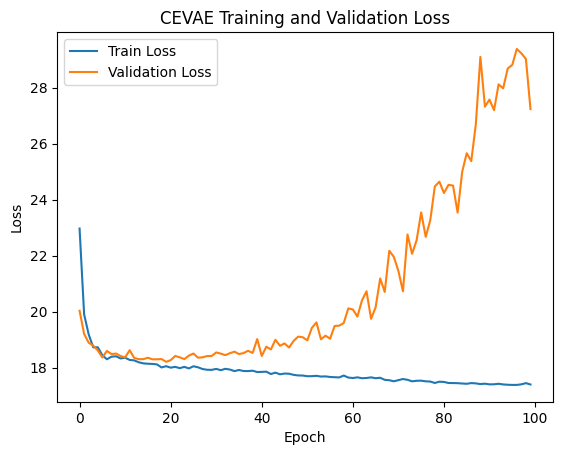

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.32447


Estimated (test) ATE: 1.3245
True ATE: 1.0145


In [69]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training and Validation Loss')
plt.legend()
plt.show()

# Estimate ITEs and ATE
ite = cevae.ite(x_test)
ate = ite.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate:.4f}")
print(f"True ATE: {data['ite'].mean().item():.4f}")

## General function for the experiments

In [70]:
def run_experiment(
    param_grid: dict,
    data_fn: callable,
    model_cls: type,
    metrics_fns: dict,
    data_kwargs: dict,
    model_kwargs: dict,
    fit_kwargs: dict,
    test_size: float = 0.2,
    random_state: int = 0,
):
    """
    Sweeps over one or more parameters (given in param_grid) and returns a DataFrame
    of results.

    param_grid: mapping from "stage__param_name" to list of values.
       e.g. {"data__shuffle_pct": np.linspace(0,1,11),
              "model__latent_dim": [1,2,5]}

    data_fn:        function(**data_kwargs) -> dict with keys "x","t","y","ite"
    
    model_cls:      class of your model; instantiated as model_cls(**model_kwargs)
    
    fit_kwargs:     kwargs passed to model.fit(...)
    
    metrics_fns:    mapping from metric_name -> function(model, x_te, ite_te) -> float

    Returns a pandas DataFrame with one row per combination, columns for each
    swept param plus each metric.
    """
    # 1) build list of all combinations
    keys, values = zip(*param_grid.items())
    combos = [dict(zip(keys, combo)) for combo in itertools.product(*values)]

    records = []
    for combo in combos:
        # prepare stage-specific kwargs
        dk = data_kwargs.copy()
        mk = model_kwargs.copy()
        fk = fit_kwargs.copy()

        # dispatch combo entries into dk/mk/fk
        for full_key, val in combo.items():
            stage, param = full_key.split("__", 1)
            if stage == "data":
                dk[param] = val
            elif stage == "model":
                mk[param] = val
            elif stage == "fit":
                fk[param] = val
            else:
                raise ValueError(f"Unknown stage “{stage}”")

        # run one trial
        data = data_fn(**dk)
        x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
        x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
            x, t, y, ite, test_size=test_size, random_state=random_state
        )

        pyro.clear_param_store()
        model = model_cls(**mk)
        losses = model.fit(x_tr, t_tr, y_tr, **fk)

        # 4) build result row
        row = dict(combo)
        row["final_elbo"] = losses[-1] 
        for mname, mfn in metrics_fns.items():
            row[mname] = mfn(model, x_te, ite_te)
        records.append(row)

    return pd.DataFrame.from_records(records)

# ---------------------------- metrics definition ---------------------------- #

def abs_ate_error(model, x_te, ite_te):
    est = model.ite(x_te).mean().item()
    true = ite_te.mean().item()
    return abs(est - true)

def rel_ate_error(model, x_te, ite_te):
    est = model.ite(x_te).mean().item()
    true = ite_te.mean().item()
    return abs(est - true) / abs(true)

def nrmse_ite(model, x_te, ite_te):
    pred = model.ite(x_te).cpu().numpy()
    true = ite_te.cpu().numpy()
    rmse = np.sqrt(np.mean((pred - true) ** 2))
    return rmse / true.std()


In [71]:
def plot_experiment_results(results, x_param="data__shuffle_pct"):
    """
    Given a DataFrame `results` where one column is your swept parameter
    (e.g. "data__shuffle_pct") and the others are metrics, this function
    will produce one plot per metric.
    """
    # find all metric columns
    metrics = [c for c in results.columns if c != x_param]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(results[x_param], results[metric], marker="o")
        plt.xlabel(x_param)
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param}")
        plt.tight_layout()
        plt.show()

In [72]:
def plot_two_experiment_results(results, linear_results, x_param="data__shuffle_pct"):
    """
    Plot results and linear_results overlapping for each metric on the same plot.
    Assumes both DataFrames have the same x_param values and metric columns.
    """
    # find all metric columns
    metrics = [c for c in results.columns if c != x_param and c!= "final_elbo"]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(results[x_param], results[metric], marker="o", label="Results")
        plt.plot(linear_results[x_param], linear_results[metric], marker="x", label="Linear Results")
        plt.xlabel(x_param)
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param}")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [73]:
num_proxies = 10

data_defaults_non_lin = dict(
    n=1000,
    num_proxies=num_proxies,
    sigma_x=1.0,
    sigma_y=1.0,
    prior_type="gaussian",
    seed=0,
)


data_defaults_linear = dict(
    n=1000,
    beta=1.0,
    num_proxies=num_proxies,
    shuffle_pct=0.0,
    sigma_x=1.0,
    sigma_y=1.0,
    seed=0,
)

In [74]:

# data_defaults_non_lin_less_proxies = dict(
#     n=2000,
#     beta=2.0,
#     num_proxies=10,
#     prior_type="gaussian",
#     sigma_x=1.0,
#     sigma_y=1.0,
#     seed=42,
# )

# CEVAE default specification
model_defaults = dict(
    feature_dim=num_proxies,
    latent_dim=1,
    num_layers=3,   # number of hidden layers
    hidden_dim=20,  # number of hidden units in each layer
    outcome_dist="normal",
)

fit_defaults = dict(
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    weight_decay=0.0,
    log_every=0,
)

metrics = {
    "rel_ate_err": rel_ate_error,
    "nrmse_ite": nrmse_ite,
}


### experiments with model hyperparams

In [86]:
# set up params to sweep
param_grid = {
    # "data__shuffle_pct": np.linspace(0.0, 1.0, 11),
    "data__n": np.linspace(1000,10000,10, dtype=int),  # number of samples
    # "data__prior_type": ["gaussian", "uniform"],  # type of prior distribution
    # "data__sigma_x": [1.0, 2.0],  # standard deviation of x
    # "data__sigma_y": [1.0, 2.0],  # standard deviation of y
    # "model__latent_dim": [1, 2, 5],
    # "model__num_layers": [100,200,300],
    # "model__hidden_dim": [100, 200, 300],
}

# run the experiment
results = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_pyro,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)


INFO 	 Training with 8 minibatches per epoch


INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33259
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33113
INFO 	 Training with 16 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.69021
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.69055
INFO 	 Training with 24 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.45354
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.44016
INFO 	 Training with 32 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33205
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.3291
INFO 	 Training with 40 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.40082
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.4061
INFO 	 Training with 48 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33537
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33701
INFO 	 Training with 56 minibatches per epoch
INFO 	

   data__n  final_elbo  rel_ate_err  nrmse_ite
0     1000   18.188556     0.321387   0.873720
1     2000   18.963428     0.697196   1.483107
2     3000   17.939932     0.495595   1.143568
3     4000   17.378374     0.356085   0.887156
4     5000   18.294458     0.416463   1.073991
5     6000   17.764282     0.371144   0.930787
6     7000   18.054637     0.571707   1.310409
7     8000   17.921647     0.295881   0.870706
8     9000   18.291709     0.131799   0.646155
9    10000   18.548008     0.315016   0.928395


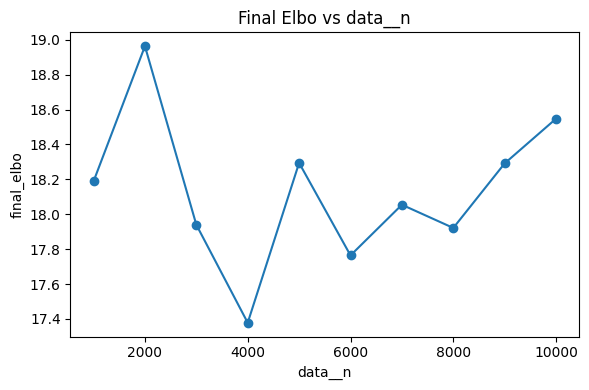

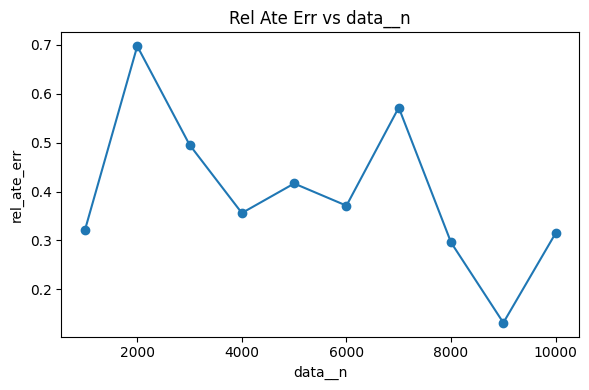

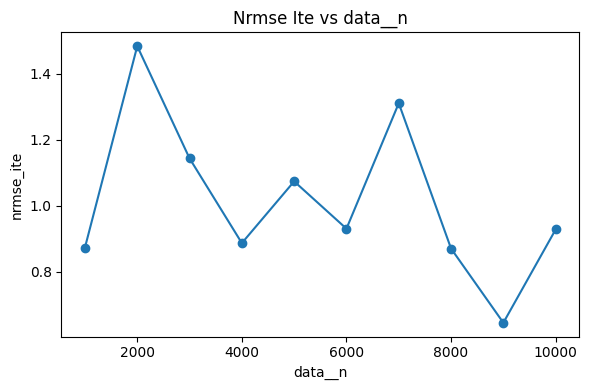

In [87]:
print(results)
plot_experiment_results(results, x_param="data__n")

### linear regressio experiment

In [88]:
# solving the problem with LINEAR REGRESSION
linear_results = run_experiment(
    param_grid   = param_grid,
    data_fn      = synthetic_dataset_pyro,  
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    data_kwargs = data_defaults_non_lin,
    model_kwargs  = {},      
    fit_kwargs   = {},
)

print(linear_results)

   data__n  final_elbo  rel_ate_err  nrmse_ite
0     1000    1.469740     0.457875   1.326758
1     2000    1.618751     0.695438   1.664585
2     3000    1.423684     0.711583   1.695991
3     4000    1.384188     0.539925   1.455826
4     5000    1.525504     0.710201   1.722484
5     6000    1.483967     0.547926   1.465008
6     7000    1.551021     0.834069   1.918796
7     8000    1.431192     0.646994   1.646607
8     9000    1.465411     0.586038   1.529881
9    10000    1.542245     0.773220   1.869244


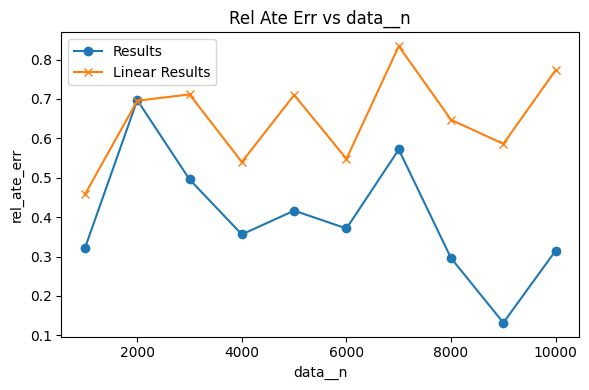

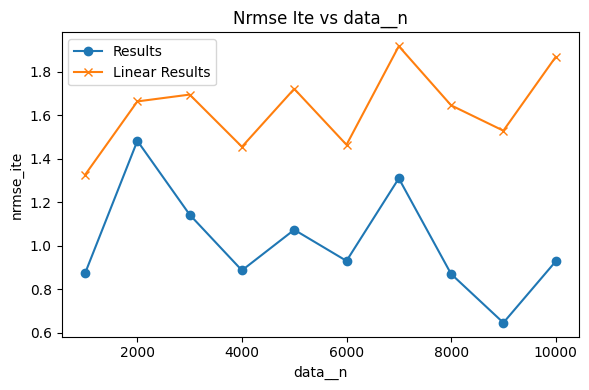

In [89]:
plot_two_experiment_results(results, linear_results, x_param="data__n")

In [ ]:
results = run_experiment(
    param_grid   = {"data__shuffle_pct": np.linspace(0, 1, 11)},
    data_fn      = synthetic_dataset_linear,  
    model_cls    = CEVAE,
    metrics_fns  = metrics,                   
    data_kwargs  = data_defaults_linear,      
    model_kwargs = model_defaults,
    fit_kwargs   = fit_defaults,
)

In [ ]:
plot_experiment_results(results)

## experiment 1: $n=1000$, error as function of number of proxies

In [ ]:
n = 1000
proxy_list = list(range(1, 111, 10))
errors = []

for num_proxies in proxy_list:
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=1.0,
        sigma_y=1.0,
        shuffle_pct=0.0,
        prior_type="gaussian",
        seed=0,
    )
    x, t, y = data["x"], data["t"], data["y"]

    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    cevae.fit(
        x, t, y,
        num_epochs=100,      # fewer epochs
        batch_size=100,
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    est_ate = cevae.ite(x).mean().item()
    true_ate = data["ite"].mean().item()
    errors.append(abs(est_ate - true_ate))


## same experiment but train/test split

In [ ]:
n = 1000
proxy_list = list(range(1, 111, 10))
errors = []
rel_ate_errors = []
nrmse_ites       = []
final_losses = []

for num_proxies in proxy_list:
    # 1) generate
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=1.0,
        sigma_y=1.0,
        shuffle_pct=0.0,
        prior_type="gaussian",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]

    # 2) split into train/test
    x_train, x_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    # 3) clear & build model
    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    # 4) fit on train
    losses= cevae.fit(
        x_train, t_train, y_train,
        num_epochs=100,
        batch_size=100,     # or use x_train.shape[0] for full-batch
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # salva l'ultimo valore
    final_losses.append(losses[-1])

    # 5) evaluate ATE on test
    est_ate = cevae.ite(x_test).mean().item()
    true_ate = ite_test.mean().item()
    errors.append(abs(est_ate - true_ate))
    

# 6) plot errore ATE
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(proxy_list, errors, marker='o')
plt.xlabel("Numero di proxy")
plt.ylabel("Errore assoluto ATE (test set)")
plt.title("ATE error vs #proxy")

# 7) plot loss finale
plt.subplot(1,2,2)
plt.plot(proxy_list, final_losses, marker='o', color='orange')
plt.xlabel("Numero di proxy")
plt.ylabel("Negative ELBO finale")
plt.title("Final training loss vs #proxy")

plt.tight_layout()
plt.show()


From this experiment we can see two things:
1. for a fixed number of data ($n=1000$) the performance of the model improves as the number of proxies increase. This make sense: the core idea of the use of VAEs to perform causal inference is that we are able to estimate the latent confounder in the big data regime, *i.e.*, in under the assumption that we have enough proxy variable of it. This is  pretty interestin result since nowadays we are in the big data regine. So given enough proxies we can estimate z better and better.
2. the minimum of the loss increases **linearly** when we increase the number of proxies. Does this make sense? Is the Elbow directly proportional (linearly) in the number of proxies (in the paper called $D_x$)? Yes.
The reconstruction term of $x$ 
$$
\mathbb{E}_q[\log(p(x|z))]
$$
where 

$$
\log(p(x|z))=\sum_{j=1}^{D_x}\log(p(x_j|z))
$$

and $p(x_j|z)\sim\mathcal{N}(\mu,\sigma^2)$, hence:

$$
\log(p(x|z))=\sum_{j=1}^{D_x}\frac{1}{2}[\log(2\pi\sigma^2)+\frac{(x_j-\mu_j(z))^2}{\sigma^2}]
$$

and for fixed $\sigma$ it is increasing with $D_x$

## same but with more metrics

In [ ]:
n = 1000
proxy_list = list(range(1, 111, 10))

rel_ate_errors = []
nrmse_ites       = []

for num_proxies in proxy_list:
    data = synthetic_dataset_pyro(
        n=n, num_proxies=num_proxies,
        sigma_x=1.0, sigma_y=1.0,
        shuffle_pct=0.0, prior_type="gaussian",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
    x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )
    cevae.fit(
        x_tr, t_tr, y_tr,
        num_epochs=100,
        batch_size=100,
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # ATE error (relative)
    est_ate  = cevae.ite(x_te).mean().item()
    true_ate = ite_te.mean().item()
    rel_ate_errors.append(abs(est_ate - true_ate) / abs(true_ate))

    # ITE RMSE & normalized RMSE
    ite_pred = cevae.ite(x_te).cpu().numpy()
    ite_true = ite_te.cpu().numpy()
    rmse      = np.sqrt(np.mean((ite_pred - ite_true)**2))
    nrmse     = rmse / ite_true.std()
    nrmse_ites.append(nrmse)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(proxy_list, rel_ate_errors, marker='o')
axes[0].set_xlabel("Numero di proxy")
axes[0].set_ylabel("Relative ATE error")
axes[0].set_title("Errore relativo di ATE")

axes[1].plot(proxy_list, nrmse_ites, marker='o', color='green')
axes[1].set_xlabel("Numero di proxy")
axes[1].set_ylabel("Normalized RMSE of ITE")
axes[1].set_title("nRMSE su ITE")

plt.tight_layout()
plt.show()


## Shuffling the proxies: less-informative proxies 

In [ ]:
n = 1000
shuffle_list = np.linspace(0.0, 1.0, 11)  # from 0% to 100% shuffled proxies
num_proxies = 100

rel_ate_errors = []
nrmse_ites       = []
final_losses = []

for s in shuffle_list:
    # 1) generate
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=1.0,
        sigma_y=1.0,
        shuffle_pct=s,
        prior_type="gaussian",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
    x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    # 3) clear & build model
    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    # 4) fit on train
    losses= cevae.fit(
        x_tr, t_tr, y_tr,
        num_epochs=100,
        batch_size=100,     # or use x_train.shape[0] for full-batch
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # salva l'ultimo valore
    final_losses.append(losses[-1])

    # 5) evaluate ATE on test
    est_ate  = cevae.ite(x_te).mean().item()
    true_ate = ite_te.mean().item()
    rel_ate_errors.append(abs(est_ate - true_ate) / abs(true_ate))

    # ITE RMSE & normalized RMSE
    ite_pred = cevae.ite(x_te).cpu().numpy()
    ite_true = ite_te.cpu().numpy()
    rmse      = np.sqrt(np.mean((ite_pred - ite_true)**2))
    nrmse     = rmse / ite_true.std()
    nrmse_ites.append(nrmse)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) ATE absolute error
axes[0].plot(shuffle_list, rel_ate_errors, marker='o')
axes[0].set_xlabel("Pct of shuffled proxies")
axes[0].set_ylabel("relative ATE (test set)")
axes[0].set_title("ATE error vs shuffled proxies")

# 2) Final training loss
axes[1].plot(shuffle_list, final_losses, marker='o', color='orange')
axes[1].set_xlabel("Pct of shuffled proxies")
axes[1].set_ylabel("Negative ELBO finale")
axes[1].set_title("Final training loss")

# 3) Normalized RMSE of ITE
axes[2].plot(shuffle_list, nrmse_ites, marker='o', color='green')
axes[2].set_xlabel("Pct of shuffled proxies")
axes[2].set_ylabel("Normalized RMSE of ITE")
axes[2].set_title("nRMSE su ITE")

plt.tight_layout()
plt.show()

this is very interesting: given enough proxies it is still able to understand the information! The problem could be in the shuffle operation, that is noth truly uninformative.

### same experiment: reverse order of decorrelation

In [ ]:
n = 1000
shuffle_list = np.linspace(1.0, 0.0, 11)  # from 0% to 100% shuffled proxies
num_proxies = 100

rel_ate_errors = []
nrmse_ites       = []
final_losses = []

for s in shuffle_list:
    # 1) generate
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=1.0,
        sigma_y=1.0,
        shuffle_pct=s,
        prior_type="gaussian",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
    x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    # 3) clear & build model
    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    # 4) fit on train
    losses= cevae.fit(
        x_tr, t_tr, y_tr,
        num_epochs=100,
        batch_size=100,     # or use x_train.shape[0] for full-batch
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # salva l'ultimo valore
    final_losses.append(losses[-1])

    # 5) evaluate ATE on test
    est_ate  = cevae.ite(x_te).mean().item()
    true_ate = ite_te.mean().item()
    rel_ate_errors.append(abs(est_ate - true_ate) / abs(true_ate))

    # ITE RMSE & normalized RMSE
    ite_pred = cevae.ite(x_te).cpu().numpy()
    ite_true = ite_te.cpu().numpy()
    rmse      = np.sqrt(np.mean((ite_pred - ite_true)**2))
    nrmse     = rmse / ite_true.std()
    nrmse_ites.append(nrmse)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) ATE absolute error
axes[0].plot(shuffle_list, rel_ate_errors, marker='o')
axes[0].set_xlabel("Pct of shuffled proxies")
axes[0].set_ylabel("relative ATE (test set)")
axes[0].set_title("ATE error vs shuffled proxies")

# 2) Final training loss
axes[1].plot(shuffle_list, final_losses, marker='o', color='orange')
axes[1].set_xlabel("Pct of shuffled proxies")
axes[1].set_ylabel("Negative ELBO finale")
axes[1].set_title("Final training loss")

# 3) Normalized RMSE of ITE
axes[2].plot(shuffle_list, nrmse_ites, marker='o', color='green')
axes[2].set_xlabel("Pct of shuffled proxies")
axes[2].set_ylabel("Normalized RMSE of ITE")
axes[2].set_title("nRMSE su ITE")

plt.tight_layout()
plt.show()

same result: the hypothesis wat some memory issue with the parameters. the VAE is able to find correlations (given enough data) even with shuffled data!

## Robustness over $\sigma_X$

In [ ]:
n = 1000
sigma_list = np.linspace(1.0, 5.0, 10)  # from 0% to 100% shuffled proxies
num_proxies = 100

rel_ate_errors = []
nrmse_ites       = []
final_losses = []

for s in sigma_list:
    # 1) generate
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=s,
        sigma_y=1.0,
        shuffle_pct=0.0,
        prior_type="gaussian",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
    x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    # 3) clear & build model
    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    # 4) fit on train
    losses= cevae.fit(
        x_tr, t_tr, y_tr,
        num_epochs=100,
        batch_size=100,     # or use x_train.shape[0] for full-batch
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # salva l'ultimo valore
    final_losses.append(losses[-1])

    # 5) evaluate ATE on test
    est_ate  = cevae.ite(x_te).mean().item()
    true_ate = ite_te.mean().item()
    rel_ate_errors.append(abs(est_ate - true_ate) / abs(true_ate))

    # ITE RMSE & normalized RMSE
    ite_pred = cevae.ite(x_te).cpu().numpy()
    ite_true = ite_te.cpu().numpy()
    rmse      = np.sqrt(np.mean((ite_pred - ite_true)**2))
    nrmse     = rmse / ite_true.std()
    nrmse_ites.append(nrmse)



In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# 1) ATE absolute error
axes[0].plot(sigma_list, rel_ate_errors, marker='o')
axes[0].set_xlabel("variance of proxies")
axes[0].set_ylabel("relative ATE (test set)")
axes[0].set_title("ATE error vs shuffled proxies")

# 2) Final training loss
axes[1].plot(sigma_list, final_losses, marker='o', color='orange')
axes[1].set_xlabel("variance of proxies")
axes[1].set_ylabel("Negative ELBO finale")
axes[1].set_title("Final training loss")

# 3) Normalized RMSE of ITE
axes[2].plot(sigma_list, nrmse_ites, marker='o', color='green')
axes[2].set_xlabel("variance of proxies")
axes[2].set_ylabel("Normalized RMSE of ITE")
axes[2].set_title("nRMSE su ITE")

plt.tight_layout()
plt.show()

## Robustness over prior misspecification

In [ ]:
n = 1000
proxy_list = np.linspace(1, 100, 10)

rel_ate_errors = []
nrmse_ites       = []
final_losses = []

for num_proxies in proxy_list:
    num_proxies = int(num_proxies)  # ensure integer
    # 1) generate
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=1.0,
        sigma_y=1.0,
        shuffle_pct=0.0,
        prior_type="bimodal",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
    x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    # 3) clear & build model
    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    # 4) fit on train
    losses= cevae.fit(
        x_tr, t_tr, y_tr,
        num_epochs=100,
        batch_size=100,     # or use x_train.shape[0] for full-batch
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # salva l'ultimo valore
    final_losses.append(losses[-1])

    # 5) evaluate ATE on test
    est_ate  = cevae.ite(x_te).mean().item()
    true_ate = ite_te.mean().item()
    rel_ate_errors.append(abs(est_ate - true_ate) / abs(true_ate))

    # ITE RMSE & normalized RMSE
    ite_pred = cevae.ite(x_te).cpu().numpy()
    ite_true = ite_te.cpu().numpy()
    rmse      = np.sqrt(np.mean((ite_pred - ite_true)**2))
    nrmse     = rmse / ite_true.std()
    nrmse_ites.append(nrmse)



In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) ATE absolute error
axes[0].plot(proxy_list, rel_ate_errors, marker='o')
axes[0].set_xlabel("number of proxies")
axes[0].set_ylabel("relative ATE (test set)")
axes[0].set_title("ATE error vs shuffled proxies")

# 2) Final training loss
axes[1].plot(proxy_list, final_losses, marker='o', color='orange')
axes[1].set_xlabel("number of proxies")
axes[1].set_ylabel("Negative ELBO finale")
axes[1].set_title("Final training loss")

# 3) Normalized RMSE of ITE
axes[2].plot(proxy_list, nrmse_ites, marker='o', color='green')
axes[2].set_xlabel("number of proxies")
axes[2].set_ylabel("Normalized RMSE of ITE")
axes[2].set_title("nRMSE su ITE")

plt.tight_layout()
plt.show()